In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [41]:
# Load the phenotypic data
phenotype = "YPD_doublingtime"
phenotype_data_path = f"data/y_{phenotype}.csv"
y_phenotype = pd.read_csv(phenotype_data_path)
y_phenotype.drop(columns='Yeast_ID', inplace=True)


In [9]:
mutations = pd.read_csv("results/mutations_importance_ranking2.csv")
mutations.drop(columns="Frequency", inplace=True)
mutations_important = mutations.iloc[:17, 0]
mutations_important

0            YLR154C-H
1              YER188W
2        YML009C-A_CNV
3          YGR074W_CNV
4          YMR326C_CNV
5          YHR043C_CNV
6        YML057C-A_CNV
7          YFL053W_CNV
8     YPR196W_312_T->I
9          YPL257W_CNV
10             YKR105C
11             YMR173W
12         YNR072W_CNV
13         YCR040W_CNV
14         YKL223W_CNV
15         YOR392W_CNV
16         YDR038C_CNV
Name: Feature_ID, dtype: object

In [5]:
# Save the X_matrix DataFrame to a pickle file
X_matrix = pd.read_csv(f"data/X_matrix_{phenotype}.csv")
X_matrix_output_path = f"data/X_matrix_{phenotype}.pkl"
X_matrix.to_pickle(X_matrix_output_path)
print(f"Combined matrix X saved to {X_matrix_output_path}")

Combined matrix X saved to data/X_matrix_YPD_doublingtime.pkl


In [11]:
X_matrix = pd.read_pickle(f"data/X_matrix_{phenotype}.pkl")


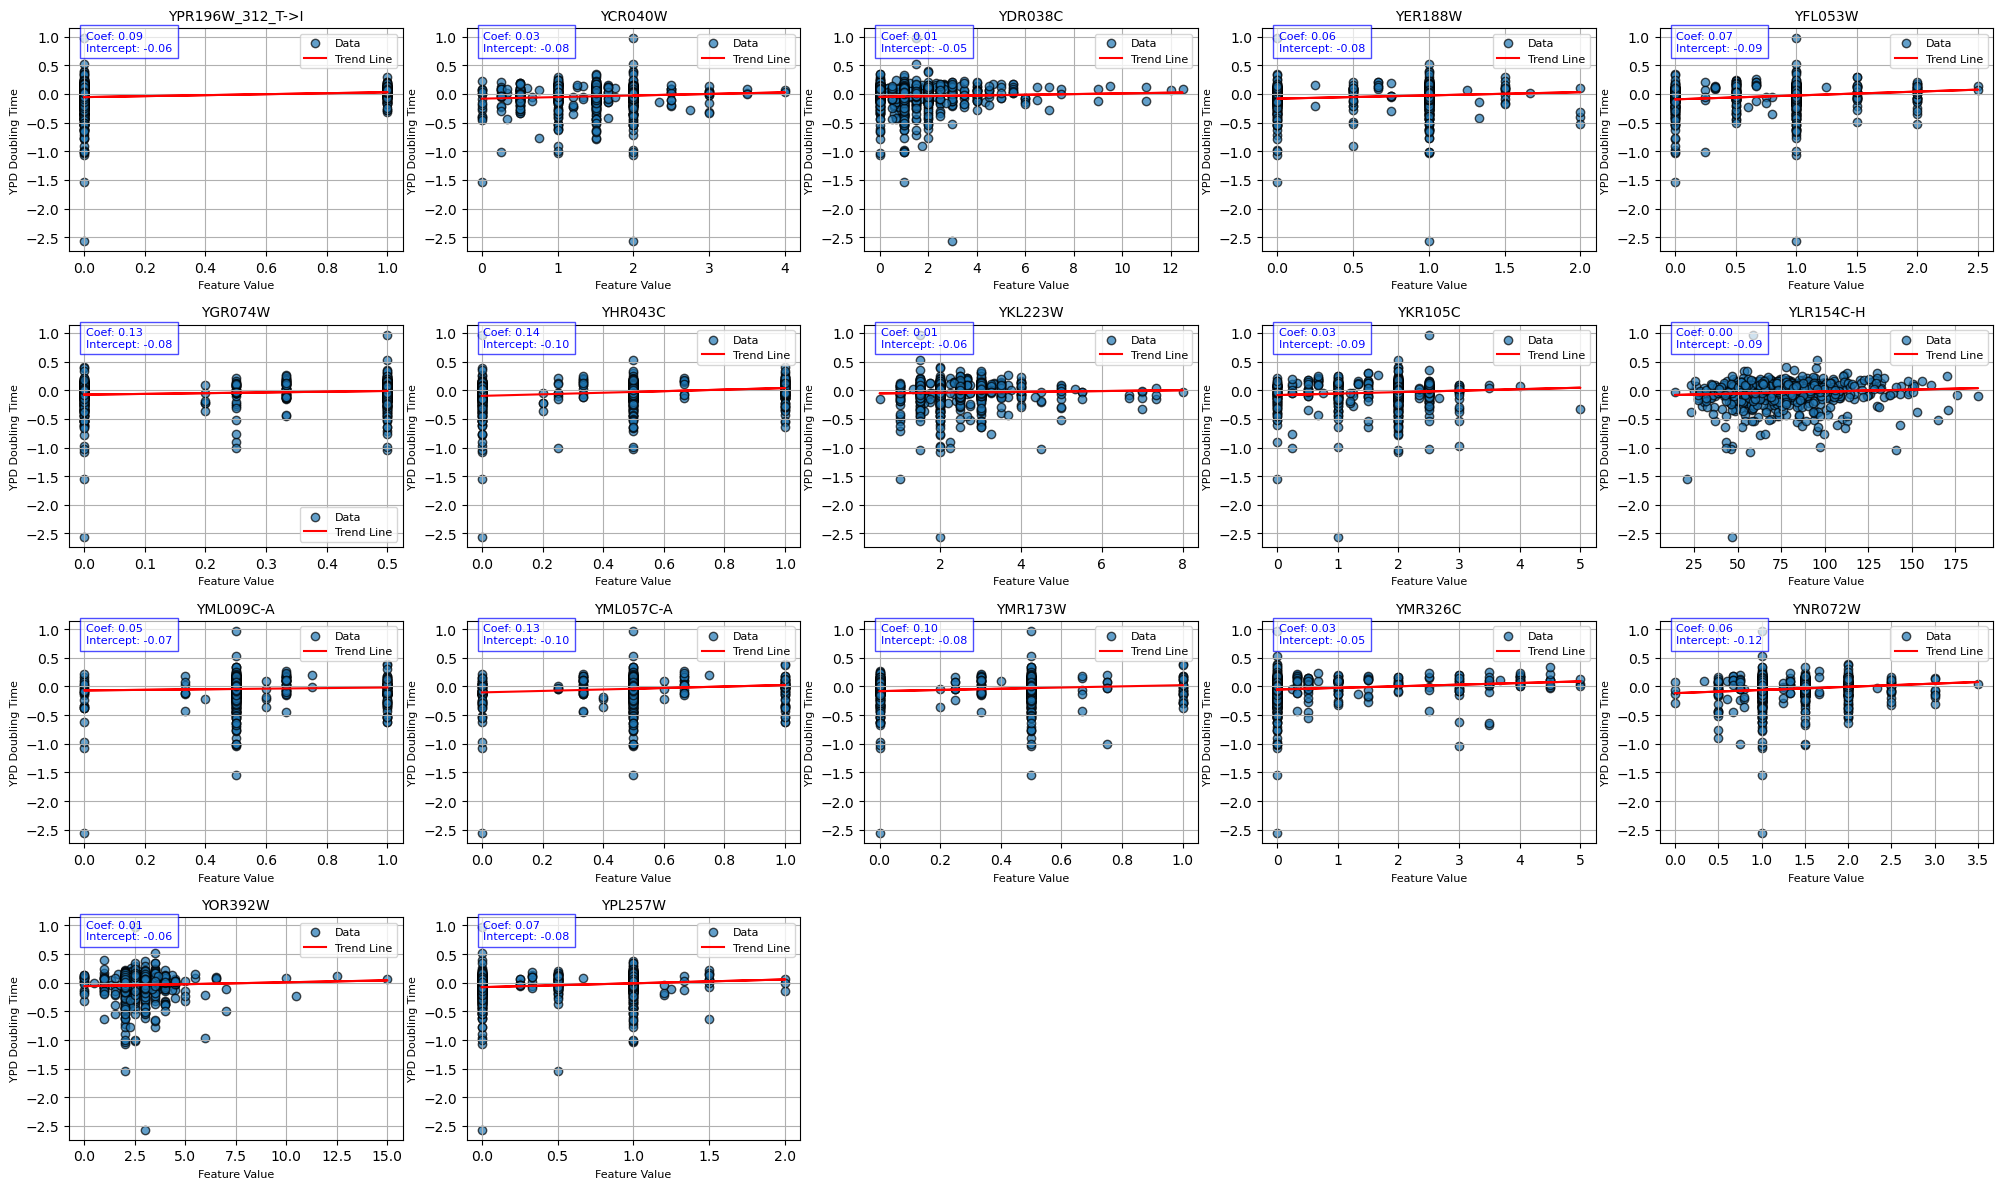

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math

# Select the column names in X_matrix that are present in mutations_important
filter_keys = mutations_important.tolist()  # Extract keys from the first column of mutations_important

# Filter X_matrix columns based on keys in filter_keys
selected_columns = X_matrix[[col for col in X_matrix.columns if col in filter_keys or col + '_CNV' in filter_keys]]

# Number of features to plot
num_features = len(selected_columns.columns)

# Define the grid layout (4 rows x 5 columns, to fit 17 plots)
num_cols = 5
num_rows = math.ceil(num_features / num_cols)

# Create the figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 12))
axes = axes.flatten()  # Flatten the axes for easy iteration

# Plot each feature with a regression line
for idx, col in enumerate(selected_columns.columns):
    x = selected_columns[col].values.reshape(-1, 1)  # Reshape for sklearn
    y = y_phenotype.values.flatten()  # Flatten y to a 1D array

    # Fit linear regression
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)

    # Extract coefficients and intercept
    coef = float(model.coef_[0])  # Convert to scalar
    intercept = float(model.intercept_)  # Convert to scalar

    # Scatter plot
    axes[idx].scatter(x.flatten(), y, alpha=0.7, edgecolor='k', label='Data')
    
    # Regression line
    axes[idx].plot(x.flatten(), y_pred, color='red', label='Trend Line')
    
    # Add titles and labels
    axes[idx].set_title(f'{col}', fontsize=10)
    axes[idx].set_xlabel('Feature Value', fontsize=8)
    axes[idx].set_ylabel('YPD Doubling Time', fontsize=8)
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True)

    # Annotate the plot with coefficient and intercept
    axes[idx].text(0.05, 0.9, f'Coef: {coef:.2f}\nIntercept: {intercept:.2f}', 
                   transform=axes[idx].transAxes, fontsize=8, color='blue',
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='blue'))

# Remove any unused subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()

# Save the figure
plot_path = "results/plots/all_features_with_trend_and_coefficients.png"
plt.savefig(plot_path, bbox_inches='tight')

# Show the figure
plt.show()


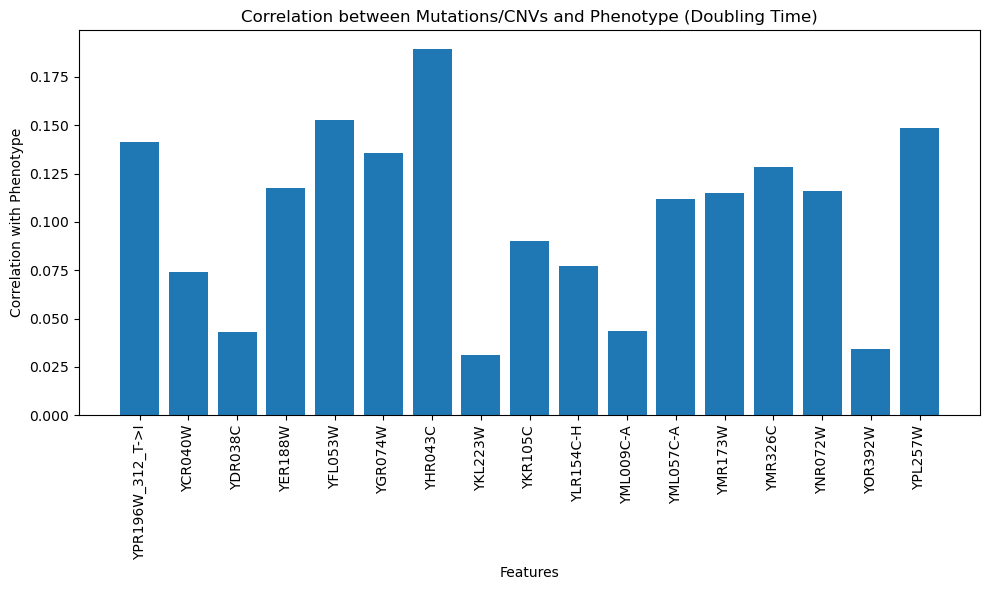

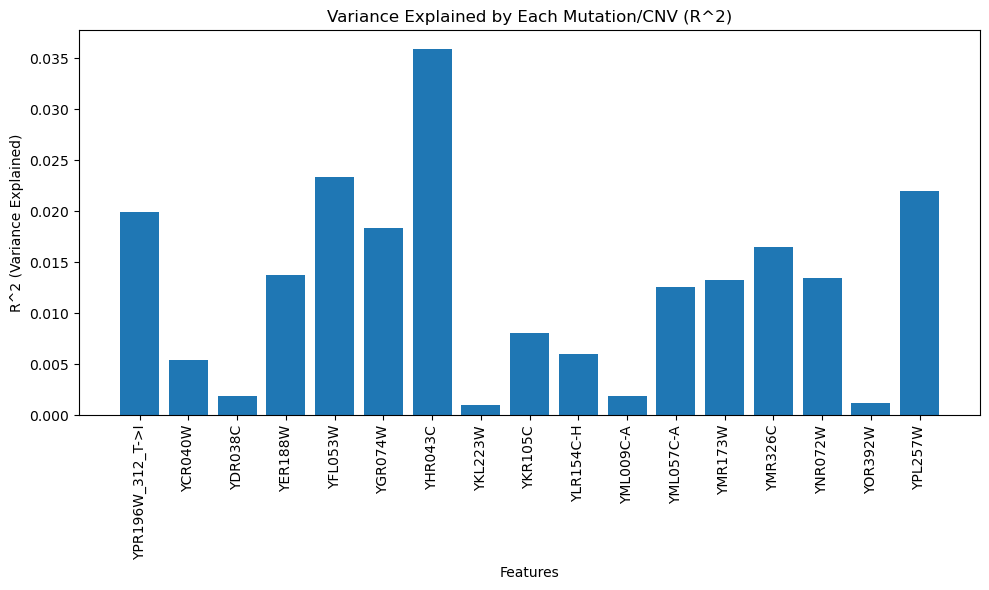

Top 5 Pairs of Features (R^2 values):
('YGR074W', 'YHR043C'): R^2 = 0.0535
('YHR043C', 'YGR074W'): R^2 = 0.0535
('YHR043C', 'YPR196W_312_T->I'): R^2 = 0.0518
('YPR196W_312_T->I', 'YHR043C'): R^2 = 0.0518
('YHR043C', 'YPL257W'): R^2 = 0.0501

Top 5 Triplets of Features (R^2 values):
('YPR196W_312_T->I', 'YGR074W', 'YHR043C'): R^2 = 0.0699
('YPR196W_312_T->I', 'YHR043C', 'YGR074W'): R^2 = 0.0699
('YGR074W', 'YPR196W_312_T->I', 'YHR043C'): R^2 = 0.0699
('YGR074W', 'YHR043C', 'YPR196W_312_T->I'): R^2 = 0.0699
('YHR043C', 'YPR196W_312_T->I', 'YGR074W'): R^2 = 0.0699


In [63]:
# Example DataFrames (ensure these are defined in your environment)
# X_matrix: DataFrame of features (mutations and CNVs)
# mutations_important: DataFrame with the important mutations and CNVs
# y_phenotype: Series or DataFrame of the phenotype (e.g., doubling time)

# Select the column names in X_matrix that are present in mutations_important
filter_keys = mutations_important.tolist()  # Extract keys from the first column of filter_df

# Filter X_matrix columns based on keys in filter_keys
selected_columns = X_matrix[[col for col in X_matrix.columns if col in filter_keys or col+'_CNV' in filter_keys]]

# Create two lists: one for columns ending with '_CNV' and one for others
cnv_columns = selected_columns[[col for col in selected_columns if not '->' in col]]
non_cnv_columns = [col for col in selected_columns.columns if '->' in col]

y_phenotype = y_phenotype.values.flatten()  # Convert to 1D array

# Calculate correlation for each column with the phenotype
correlations = {}
for col in selected_columns:
    correlations[col] = X_matrix[col].corr(pd.Series(y_phenotype, index=X_matrix.index))

# Plot correlations
plt.figure(figsize=(10, 6))
plt.bar(correlations.keys(), correlations.values())
plt.xticks(rotation=90)
plt.title('Correlation between Mutations/CNVs and Phenotype (Doubling Time)')
plt.xlabel('Features')
plt.ylabel('Correlation with Phenotype')
plt.tight_layout()

# Save the plot
plot_path = f"results/plots/correlation_plot_{phenotype}.png"
plt.savefig(plot_path)

plt.show()

# Calculate R^2 (variance explained) for each feature using Linear Regression
r_squared = {}
for col in selected_columns:
    model = LinearRegression()
    X = X_matrix[[col]].values.reshape(-1, 1)  # Reshape for single feature
    y = y_phenotype
    model.fit(X, y)
    y_pred = model.predict(X)
    r_squared[col] = r2_score(y, y_pred)

# Plot R^2 values
plt.figure(figsize=(10, 6))
plt.bar(r_squared.keys(), r_squared.values())
plt.xticks(rotation=90)
plt.title('Variance Explained by Each Mutation/CNV (R^2)')
plt.xlabel('Features')
plt.ylabel('R^2 (Variance Explained)')
plt.tight_layout()

# Save the plot
plot_path_r2 = f"results/plots/r2_plot_{phenotype}.png"
plt.savefig(plot_path_r2)

plt.show()

# Evaluate pairs and triplets of features to assess their combined explanatory power
# For pairs of features
pairwise_r_squared = {}
for col1 in selected_columns:
    for col2 in selected_columns:
        if col1 != col2:
            X = X_matrix[[col1, col2]]
            model = LinearRegression()
            model.fit(X, y_phenotype)
            y_pred = model.predict(X)
            pairwise_r_squared[(col1, col2)] = r2_score(y_phenotype, y_pred)

# For triplets of features
triplet_r_squared = {}
for col1 in selected_columns:
    for col2 in selected_columns:
        for col3 in selected_columns:
            if col1 != col2 and col2 != col3 and col1 != col3:
                X = X_matrix[[col1, col2, col3]]
                model = LinearRegression()
                model.fit(X, y_phenotype)
                y_pred = model.predict(X)
                triplet_r_squared[(col1, col2, col3)] = r2_score(y_phenotype, y_pred)

# Print the R^2 values for the best pairs and triplets
top_pairs = sorted(pairwise_r_squared.items(), key=lambda x: x[1], reverse=True)[:5]
top_triplets = sorted(triplet_r_squared.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 Pairs of Features (R^2 values):")
for pair, r2 in top_pairs:
    print(f"{pair}: R^2 = {r2:.4f}")

print("\nTop 5 Triplets of Features (R^2 values):")
for triplet, r2 in top_triplets:
    print(f"{triplet}: R^2 = {r2:.4f}")
